# Customer Revenue Leakage – Exploratory Data Analysis

**Objective:**  
Identify revenue leakage patterns caused by discounts, negative margins,
and customer behavior.

**Dataset:** Retail transactional sales data


## Data Loading & Initial Inspection


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/sales.csv")
df.head()



,order_id,order_date,ship_date,customer_id,region,state,category,sub_category,product_name,sales,quantity,discount,profit
0,CA-2019-100006,2019-09-08,2019-09-13,CG-12520,West,California,Furniture,Chairs,Office Chair,261.96,2,0.0,41.91
1,CA-2019-100090,2019-07-19,2019-07-24,EB-13870,East,New York,Technology,Phones,iPhone,731.94,3,0.0,219.58
2,CA-2019-100293,2019-03-14,2019-03-19,KM-16375,Central,Texas,Office Supplies,Binders,Heavy Duty Binder,14.62,2,0.2,-6.87
3,CA-2019-100328,2019-01-28,2019-02-03,SM-20320,South,Florida,Technology,Accessories,Wireless Mouse,957.58,5,0.2,167.58
4,CA-2019-100363,2019-04-01,2019-04-06,AG-10270,West,Washington,Office Supplies,Paper,Printer Paper,22.37,3,0.0,10.74


In [12]:
df.shape

(10, 13)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      10 non-null     object 
 1   order_date    10 non-null     object 
 2   ship_date     10 non-null     object 
 3   customer_id   10 non-null     object 
 4   region        10 non-null     object 
 5   state         10 non-null     object 
 6   category      10 non-null     object 
 7   sub_category  10 non-null     object 
 8   product_name  10 non-null     object 
 9   sales         10 non-null     float64
 10  quantity      10 non-null     int64  
 11  discount      10 non-null     float64
 12  profit        10 non-null     float64
dtypes: float64(3), int64(1), object(9)
memory usage: 1.1+ KB


In [14]:
df.describe()

,sales,quantity,discount,profit
count,10.000000,10.000000,10.00000,10.000000
mean,380.886000,3.500000,0.10000,20.309000
std,418.161996,1.581139,0.11547,162.448214
min,14.620000,2.000000,0.00000,-383.030000
25%,38.795000,2.250000,0.00000,-1.305000
50%,158.720000,3.000000,0.05000,15.650000
75%,707.950000,4.000000,0.20000,105.877500
max,1044.630000,7.000000,0.30000,219.580000


In [15]:
df.isna().sum()

order_id        0
order_date      0
ship_date       0
customer_id     0
region          0
state           0
category        0
sub_category    0
product_name    0
sales           0
quantity        0
discount        0
profit          0
dtype: int64

In [17]:
df.duplicated().sum()

0

## Data Quality Checks
- Missing values
- Duplicates
- Date formatting

In [18]:
df["order_date"] = pd.to_datetime(df["order_date"])
df["ship_date"] = pd.to_datetime(df["ship_date"])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_id      10 non-null     object        
 1   order_date    10 non-null     datetime64[ns]
 2   ship_date     10 non-null     datetime64[ns]
 3   customer_id   10 non-null     object        
 4   region        10 non-null     object        
 5   state         10 non-null     object        
 6   category      10 non-null     object        
 7   sub_category  10 non-null     object        
 8   product_name  10 non-null     object        
 9   sales         10 non-null     float64       
 10  quantity      10 non-null     int64         
 11  discount      10 non-null     float64       
 12  profit        10 non-null     float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(7)
memory usage: 1.1+ KB


In [22]:
df[df["profit"] < 0]

,order_id,order_date,ship_date,customer_id,region,state,category,sub_category,product_name,sales,quantity,discount,profit
2,CA-2019-100293,2019-03-14,2019-03-19,KM-16375,Central,Texas,Office Supplies,Binders,Heavy Duty Binder,14.62,2,0.2,-6.87
5,CA-2019-100706,2019-09-20,2019-09-25,LC-16885,Central,Illinois,Furniture,Tables,Conference Table,1044.63,3,0.3,-383.03
9,CA-2020-101308,2020-06-21,2020-06-26,DK-13090,Central,Ohio,Office Supplies,Art,Sketch Pens,35.44,4,0.2,-5.32


In [23]:
df["discount"].describe()

count    10.00000
mean      0.10000
std       0.11547
min       0.00000
25%       0.00000
50%       0.05000
75%       0.20000
max       0.30000
Name: discount, dtype: float64

## Revenue & Margin Analysis
Focus on:
- Negative profit orders
- High discount impact
- Category & region-wise leakage


In [2]:
customer_perf = (
    df.groupby("customer_id")
      .agg(
          total_sales=("sales", "sum"),
          total_profit=("profit", "sum"),
          avg_discount=("discount", "mean"),
          order_count=("order_id", "nunique")
      )
      .reset_index()
)

customer_perf.head()


,customer_id,total_sales,total_profit,avg_discount,order_count
0,AG-10270,22.37,10.74,0.0,1
1,AR-10825,635.98,127.20,0.1,1
2,CG-12520,261.96,41.91,0.0,1
3,DK-13090,35.44,-5.32,0.2,1
4,EB-13870,731.94,219.58,0.0,1


In [3]:
customer_perf["profit_margin_pct"] = (
    customer_perf["total_profit"] / customer_perf["total_sales"] * 100
)

customer_perf.head()


,customer_id,total_sales,total_profit,avg_discount,order_count,profit_margin_pct
0,AG-10270,22.37,10.74,0.0,1,48.010729
1,AR-10825,635.98,127.20,0.1,1,20.000629
2,CG-12520,261.96,41.91,0.0,1,15.998626
3,DK-13090,35.44,-5.32,0.2,1,-15.011287
4,EB-13870,731.94,219.58,0.0,1,29.999727


In [4]:
leakage_customers = customer_perf[
    (customer_perf["total_sales"] > customer_perf["total_sales"].median()) &
    (customer_perf["total_profit"] <= 0)
]

leakage_customers


,customer_id,total_sales,total_profit,avg_discount,order_count,profit_margin_pct
7,LC-16885,1044.63,-383.03,0.3,1,-36.666571


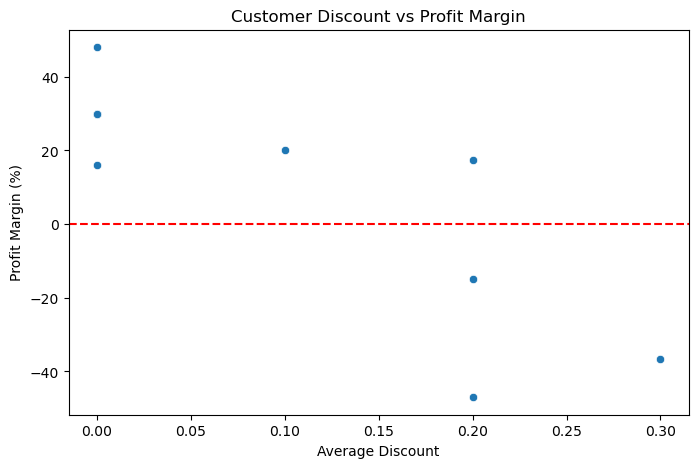

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=customer_perf,
    x="avg_discount",
    y="profit_margin_pct"
)
plt.axhline(0, color="red", linestyle="--")
plt.title("Customer Discount vs Profit Margin")
plt.xlabel("Average Discount")
plt.ylabel("Profit Margin (%)")
plt.show()



In [6]:
customer_perf["discount_band"] = pd.cut(
    customer_perf["avg_discount"],
    bins=[-0.01, 0.05, 0.15, 0.30],
    labels=["Low Discount", "Medium Discount", "High Discount"]
)

customer_perf.groupby("discount_band")[["total_sales", "total_profit", "profit_margin_pct"]].mean()


C:\Users\Shivam Agrawal\AppData\Local\Temp\ipykernel_13052\3347715955.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  customer_perf.groupby("discount_band")[["total_sales", "total_profit", "profit_margin_pct"]].mean()


,total_sales,total_profit,profit_margin_pct
discount_band,,,
Low Discount,224.1220,60.706,30.801193
Medium Discount,635.9800,127.200,20.000629
High Discount,513.0675,-56.910,-20.291979


In [7]:
def customer_action(row):
    if row["profit_margin_pct"] < 0:
        return "Fix Pricing / Reduce Discount"
    elif row["profit_margin_pct"] < 5:
        return "Monitor"
    else:
        return "Healthy"

customer_perf["action_segment"] = customer_perf.apply(customer_action, axis=1)

customer_perf["action_segment"].value_counts()


action_segment
Healthy                          7
Fix Pricing / Reduce Discount    3
Name: count, dtype: int64

In [8]:
df_leak = df.merge(
    customer_perf[["customer_id", "action_segment"]],
    on="customer_id",
    how="left"
)

df_leak.head()


,order_id,order_date,ship_date,customer_id,region,state,category,sub_category,product_name,sales,quantity,discount,profit,action_segment
0,CA-2019-100006,2019-09-08,2019-09-13,CG-12520,West,California,Furniture,Chairs,Office Chair,261.96,2,0.0,41.91,Healthy
1,CA-2019-100090,2019-07-19,2019-07-24,EB-13870,East,New York,Technology,Phones,iPhone,731.94,3,0.0,219.58,Healthy
2,CA-2019-100293,2019-03-14,2019-03-19,KM-16375,Central,Texas,Office Supplies,Binders,Heavy Duty Binder,14.62,2,0.2,-6.87,Fix Pricing / Reduce Discount
3,CA-2019-100328,2019-01-28,2019-02-03,SM-20320,South,Florida,Technology,Accessories,Wireless Mouse,957.58,5,0.2,167.58,Healthy
4,CA-2019-100363,2019-04-01,2019-04-06,AG-10270,West,Washington,Office Supplies,Paper,Printer Paper,22.37,3,0.0,10.74,Healthy


In [9]:
df_leak.groupby(["category", "action_segment"])["profit"].sum().reset_index()


,category,action_segment,profit
0,Furniture,Fix Pricing / Reduce Discount,-383.03
1,Furniture,Healthy,56.57
2,Office Supplies,Fix Pricing / Reduce Discount,-12.19
3,Office Supplies,Healthy,27.38
4,Technology,Healthy,514.36


In [10]:
df_leak.groupby(["region", "action_segment"])["profit"].sum().reset_index()


,region,action_segment,profit
0,Central,Fix Pricing / Reduce Discount,-395.22
1,East,Healthy,236.22
2,South,Healthy,294.78
3,West,Healthy,67.31


## Final Business Insights

- Revenue leakage is driven by a small group of high-discount customers
- High discount dependency directly reduces customer profit margins
- Leakage is concentrated in Furniture and Office Supplies categories
- Central region shows the highest leakage risk

## Recommendations

- Introduce discount approval or caps for high-risk customers
- Re-negotiate pricing for loss-making customers
- Track customer-level margin KPIs, not just revenue
- Review regional discounting policies, especially for Central region


